In [1]:
import os
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import numpy as np
import pandas as pd
from scipy.misc import derivative
import scipy.integrate as intg
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow.keras
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import Constant, RandomNormal

from sklearn.metrics import mean_squared_error
from astroNN.nn.layers import MCDropout

In [2]:
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Please install GPU version of TF


In [3]:
data_folder = 'Data_SNIa_LSST/'
dfp = pd.read_csv(data_folder+'hubble_diagram_Pr.txt', skiprows=4, sep=' ')
dfs = pd.read_csv(data_folder+'hubble_diagram_Sr.txt', skiprows=4, sep=' ')
Np = len(dfp.values)
Ns= len(dfs.values)
dfp.head()

,zCMB,zHEL,MU,MUERR,MUERR_SYS
0,0.04131,0.04131,36.31666,0.00969,0.00674
1,0.06876,0.06876,37.44798,0.00541,0.00627
2,0.13121,0.13121,38.94492,0.01969,0.00868
3,0.18499,0.18499,39.75545,0.01338,0.00658
4,0.24503,0.24503,40.42469,0.01068,0.00590


In [4]:
dfp['zCMB'].values

array([0.04131, 0.06876, 0.13121, 0.18499, 0.24503, 0.31077, 0.38392,
       0.46752, 0.55669, 0.66538, 0.78147, 0.92328, 1.08255, 1.24447])

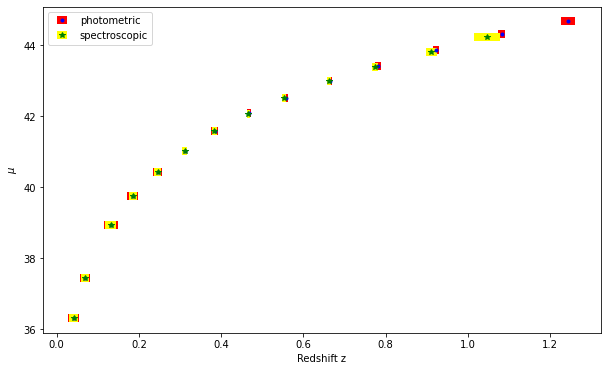

In [5]:
fig = plt.figure(figsize=(10, 6))
plt.errorbar(dfp['zCMB'].values, dfp['MU'].values, xerr=dfp['MUERR_SYS'].values+dfp['MUERR_SYS'].values, fmt='.', color='b', elinewidth=8, ecolor='red', label='photometric')
plt.errorbar(dfs['zCMB'].values, dfs['MU'].values, xerr=dfs['MUERR_SYS'].values+dfs['MUERR_SYS'].values, fmt='*', color='g', elinewidth=8, ecolor='yellow', label='spectroscopic')
plt.ylabel("$\mu$")
plt.xlabel("Redshift z")
plt.legend()

In [6]:
dfp['errors'] = dfp['MUERR_SYS'].values+dfp['MUERR_SYS'].values
dfp.head()

,zCMB,zHEL,MU,MUERR,MUERR_SYS,errors
0,0.04131,0.04131,36.31666,0.00969,0.00674,0.01348
1,0.06876,0.06876,37.44798,0.00541,0.00627,0.01254
2,0.13121,0.13121,38.94492,0.01969,0.00868,0.01736
3,0.18499,0.18499,39.75545,0.01338,0.00658,0.01316
4,0.24503,0.24503,40.42469,0.01068,0.00590,0.01180


In [7]:
dfp = dfp[['zCMB', 'MU', 'errors']]

In [8]:
len(dfp)

14

In [9]:
dfp.head()

,zCMB,MU,errors
0,0.04131,36.31666,0.01348
1,0.06876,37.44798,0.01254
2,0.13121,38.94492,0.01736
3,0.18499,39.75545,0.01316
4,0.24503,40.42469,0.01180


In [10]:
noise1x = 0.005*np.random.rand(len(dfp))
noise1y = np.zeros((14, 2))
noise1y[:,0] = noise1x * 2
noise1y[:,1] = noise1x * 0.1

noise2x = 0.005*np.random.rand(len(dfp))
noise2y = np.zeros((14, 2))
noise2y[:,0] = noise2x * 2
noise2y[:,1] = noise2x * 0.1


In [11]:
np.shape(noise1y)

(14, 2)

In [12]:
z_or = dfp.values[:,0]
y_or = dfp.values[:,1:]

z = np.append(z_or, z_or+noise1x)
z = np.append(z, z_or+noise2x)

y = np.append(y_or, y_or+noise1y, axis=0)
y = np.append(y, y_or+noise2y, axis=0)


randomize = np.random.permutation(len(z))
z = z[randomize]
y = y[randomize]

In [13]:
np.shape(y), np.shape(z)

((42, 2), (42,))

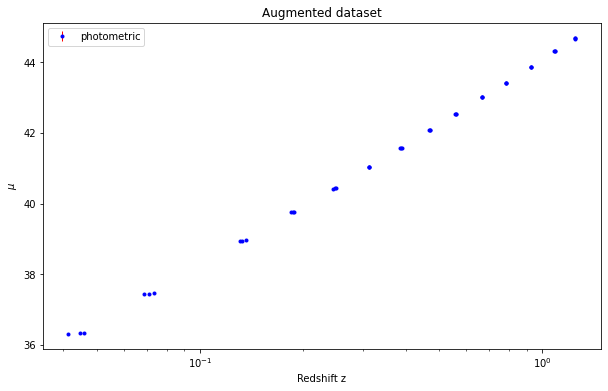

In [14]:
fig = plt.figure(figsize=(10, 6))
plt.errorbar(z, y[:,0], yerr=y[:,1], fmt='.', color='b', elinewidth=1, ecolor='red', label='photometric')
plt.ylabel("$\mu$")
plt.xlabel("Redshift z")
plt.title("Augmented dataset")
plt.xscale('log')
plt.legend()

In [15]:
scalerz = StandardScaler()
scalerz.fit(z.reshape(-1,1))
# apply transform
z = scalerz.transform(z.reshape(-1,1))

In [16]:
split = 0.9
ntrain = int(split * len(z))
indx = [ntrain]
z_train, z_test = np.split(z, indx)
y_train, y_test = np.split(y, indx)

In [17]:
def RHSquared_a_owacdm(a, w0, wa, Om):
    rhow = a**(-3*(1.0+w0+wa))*np.exp(-3*wa*(1-a))
    return (Om/a**3+(1.0-Om)*rhow)

def DistIntegrand_a(a, w0, wa, Om):
        return 1./np.sqrt(RHSquared_a_owacdm(a, w0, wa, Om))/a**2
    
def Da_z(z, w0, wa, Om):
        r = intg.quad(DistIntegrand_a, 1./(1+z), 1, args=(w0, wa, Om))
        r = r[0]
        return r

### Hay que revisar esta constante en el return
def distance_modulus(z, w0=-1, wa=0.0, Om=0.23):
    return 5*np.log10(Da_z(z, w0, wa, Om)*(1+z))+24
# +43

zmodel = np.linspace(0.01, 2.4, 100)
flcdm = []
# fowacdm1 = []
# fowacdm2 = []
# fowacdm3 = []

om = 0.27
for zzz in zmodel:
    flcdm.append(distance_modulus(zzz, w0=-1, wa=0, Om=om))

In [18]:
yy = y[:,0].reshape(-1,1)
zz = z
split = 0.8
ntrain = int(split * len(zz))
indx = [ntrain]
zz_train, zz_test = np.split(zz, indx)
yy_train, yy_test = np.split(yy, indx)
yy_train = np.append(yy_train, np.array([y[0], y[-1]]))
zz_train = np.append(zz_train, np.array([zz[0], zz[-1]]))
np.shape(zz_train), np.shape(yy_train), np.shape(zz_test), np.shape(yy_test)

((35,), (37,), (9, 1), (9, 1))

In [25]:
def model_regression_dropout(num_hidden):
    # Defeine Keras model for regression
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.InputLayer(batch_input_shape=((None, 1))))
    model.add(Dense(units=num_hidden[0], 
#                     kernel_regularizer=tf.keras.regularizers.l2(1e-4),
#                     kernel_initializer='he_normal', 
                    activation='relu'))
    model.add(MCDropout(0.5))
    model.add(Dense(units=num_hidden[1], 
#                     kernel_regularizer=tf.keras.regularizers.l2(1e-4),
#                     kernel_initializer='he_normal', 
                    activation='relu'))
    model.add(MCDropout(0.5))
    model.add(Dense(units=num_hidden[2], 
#                     kernel_regularizer=tf.keras.regularizers.l2(1e-4),
#                     kernel_initializer='he_normal', 
                    activation='relu'))
    model.add(MCDropout(0.5))
    model.add(Dense(units=2, activation="linear"))
    return model

#Define some parameter
batch_size = 1
# optimizer = Adam(lr=.005)
optimizer = Adam(learning_rate=0.0001)


# Compile Keras model
model = model_regression_dropout(num_hidden=[100,100,100, 100])
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 100)               200       
                                                                 
 MCDropout_4 (MCDropout)     (None, 100)               0         
                                                                 
 dense_5 (Dense)             (None, 100)               10100     
                                                                 
 MCDropout_5 (MCDropout)     (None, 100)               0         
                                                                 
 dense_6 (Dense)             (None, 100)               10100     
                                                                 
 MCDropout_6 (MCDropout)     (None, 100)               0         
                                                                 
 dense_7 (Dense)             (None, 2)                

In [26]:
model.compile(loss='mse', optimizer=optimizer) 
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=500)
# model2_train = model.fit(zz_train, yy_train, 
# #                          validation_split=0.0, 
#                          batch_size=batch_size, epochs=1000, verbose=1,
#                          validation_data=(zz_test, yy_test))    
model_train = model.fit(z_train, y_train, batch_size=batch_size,
                                    epochs=5000, verbose=1,
                                    validation_data=(z_test, y_test), callbacks=callback)

Epoch 1/2000
37/37 [==============================] - 1s 5ms/step - loss: 858.3185 - val_loss: 875.9002
Epoch 2/2000
37/37 [==============================] - 0s 2ms/step - loss: 856.2769 - val_loss: 868.9954
Epoch 3/2000
37/37 [==============================] - 0s 2ms/step - loss: 854.5646 - val_loss: 870.3148
Epoch 4/2000
37/37 [==============================] - 0s 2ms/step - loss: 851.1248 - val_loss: 863.8099
Epoch 5/2000
37/37 [==============================] - 0s 2ms/step - loss: 848.5633 - val_loss: 862.9054
Epoch 6/2000
37/37 [==============================] - 0s 2ms/step - loss: 846.6147 - val_loss: 858.7001
Epoch 7/2000
37/37 [==============================] - 0s 2ms/step - loss: 842.5726 - val_loss: 852.2086
Epoch 8/2000
37/37 [==============================] - 0s 2ms/step - loss: 839.2240 - val_loss: 852.1248
Epoch 9/2000
37/37 [==============================] - 0s 2ms/step - loss: 837.7849 - val_loss: 839.7207
Epoch 10/2000
37/37 [==============================] - 0s 2ms/st

37/37 [==============================] - 0s 2ms/step - loss: 53.3768 - val_loss: 50.7561
Epoch 80/2000
37/37 [==============================] - 0s 2ms/step - loss: 51.7972 - val_loss: 175.9767
Epoch 81/2000
37/37 [==============================] - 0s 2ms/step - loss: 70.5639 - val_loss: 55.6355
Epoch 82/2000
37/37 [==============================] - 0s 2ms/step - loss: 102.9889 - val_loss: 109.9326
Epoch 83/2000
37/37 [==============================] - 0s 2ms/step - loss: 58.6310 - val_loss: 64.6800
Epoch 84/2000
37/37 [==============================] - 0s 2ms/step - loss: 79.0487 - val_loss: 131.4331
Epoch 85/2000
37/37 [==============================] - 0s 2ms/step - loss: 52.0111 - val_loss: 70.6190
Epoch 86/2000
37/37 [==============================] - 0s 2ms/step - loss: 52.6104 - val_loss: 82.5317
Epoch 87/2000
37/37 [==============================] - 0s 2ms/step - loss: 62.0633 - val_loss: 69.8938
Epoch 88/2000
37/37 [==============================] - 0s 2ms/step - loss: 83.7303 

37/37 [==============================] - 0s 2ms/step - loss: 57.4816 - val_loss: 50.0770
Epoch 159/2000
37/37 [==============================] - 0s 2ms/step - loss: 34.1619 - val_loss: 22.9164
Epoch 160/2000
37/37 [==============================] - 0s 2ms/step - loss: 37.5760 - val_loss: 57.4696
Epoch 161/2000
37/37 [==============================] - 0s 2ms/step - loss: 46.4311 - val_loss: 22.3486
Epoch 162/2000
37/37 [==============================] - 0s 2ms/step - loss: 46.7469 - val_loss: 11.8017
Epoch 163/2000
37/37 [==============================] - 0s 2ms/step - loss: 52.8549 - val_loss: 39.5184
Epoch 164/2000
37/37 [==============================] - 0s 2ms/step - loss: 54.8078 - val_loss: 39.9358
Epoch 165/2000
37/37 [==============================] - 0s 2ms/step - loss: 48.8195 - val_loss: 29.9130
Epoch 166/2000
37/37 [==============================] - 0s 2ms/step - loss: 45.1140 - val_loss: 76.6259
Epoch 167/2000
37/37 [==============================] - 0s 2ms/step - loss: 62.

Epoch 237/2000
37/37 [==============================] - 0s 2ms/step - loss: 42.1061 - val_loss: 34.1629
Epoch 238/2000
37/37 [==============================] - 0s 2ms/step - loss: 27.9004 - val_loss: 25.0883
Epoch 239/2000
37/37 [==============================] - 0s 2ms/step - loss: 36.1821 - val_loss: 67.7229
Epoch 240/2000
37/37 [==============================] - 0s 2ms/step - loss: 37.5474 - val_loss: 45.7530
Epoch 241/2000
37/37 [==============================] - 0s 2ms/step - loss: 44.1314 - val_loss: 11.3794
Epoch 242/2000
37/37 [==============================] - 0s 2ms/step - loss: 50.1391 - val_loss: 35.5275
Epoch 243/2000
37/37 [==============================] - 0s 2ms/step - loss: 45.5269 - val_loss: 40.4151
Epoch 244/2000
37/37 [==============================] - 0s 2ms/step - loss: 26.2620 - val_loss: 35.3871
Epoch 245/2000
37/37 [==============================] - 0s 2ms/step - loss: 35.9738 - val_loss: 27.1120
Epoch 246/2000
37/37 [==============================] - 0s 2ms/s

Epoch 316/2000
37/37 [==============================] - 0s 2ms/step - loss: 34.6527 - val_loss: 33.7333
Epoch 317/2000
37/37 [==============================] - 0s 2ms/step - loss: 40.7870 - val_loss: 64.2089
Epoch 318/2000
37/37 [==============================] - 0s 2ms/step - loss: 36.1360 - val_loss: 19.9132
Epoch 319/2000
37/37 [==============================] - 0s 2ms/step - loss: 41.6865 - val_loss: 15.5539
Epoch 320/2000
37/37 [==============================] - 0s 2ms/step - loss: 36.2600 - val_loss: 39.3494
Epoch 321/2000
37/37 [==============================] - 0s 2ms/step - loss: 36.6798 - val_loss: 58.5357
Epoch 322/2000
37/37 [==============================] - 0s 2ms/step - loss: 31.8868 - val_loss: 110.3585
Epoch 323/2000
37/37 [==============================] - 0s 2ms/step - loss: 51.9464 - val_loss: 23.3333
Epoch 324/2000
37/37 [==============================] - 0s 2ms/step - loss: 40.0154 - val_loss: 26.3903
Epoch 325/2000
37/37 [==============================] - 0s 2ms/

Epoch 395/2000
37/37 [==============================] - 0s 2ms/step - loss: 33.7392 - val_loss: 20.2418
Epoch 396/2000
37/37 [==============================] - 0s 2ms/step - loss: 22.8678 - val_loss: 35.4192
Epoch 397/2000
37/37 [==============================] - 0s 2ms/step - loss: 32.4740 - val_loss: 25.0541
Epoch 398/2000
37/37 [==============================] - 0s 2ms/step - loss: 38.6752 - val_loss: 9.7234
Epoch 399/2000
37/37 [==============================] - 0s 2ms/step - loss: 37.4055 - val_loss: 120.5477
Epoch 400/2000
37/37 [==============================] - 0s 2ms/step - loss: 29.1854 - val_loss: 41.1889
Epoch 401/2000
37/37 [==============================] - 0s 2ms/step - loss: 47.2595 - val_loss: 64.6255
Epoch 402/2000
37/37 [==============================] - 0s 2ms/step - loss: 27.6071 - val_loss: 17.8657
Epoch 403/2000
37/37 [==============================] - 0s 2ms/step - loss: 18.2239 - val_loss: 22.4022
Epoch 404/2000
37/37 [==============================] - 0s 2ms/s

Epoch 474/2000
37/37 [==============================] - 0s 2ms/step - loss: 28.7232 - val_loss: 36.4934
Epoch 475/2000
37/37 [==============================] - 0s 2ms/step - loss: 35.0198 - val_loss: 65.1638
Epoch 476/2000
37/37 [==============================] - 0s 2ms/step - loss: 34.9907 - val_loss: 1.1519
Epoch 477/2000
37/37 [==============================] - 0s 2ms/step - loss: 34.8883 - val_loss: 6.7893
Epoch 478/2000
37/37 [==============================] - 0s 2ms/step - loss: 29.6508 - val_loss: 26.2387
Epoch 479/2000
37/37 [==============================] - 0s 2ms/step - loss: 19.3202 - val_loss: 18.8755
Epoch 480/2000
37/37 [==============================] - 0s 2ms/step - loss: 27.2207 - val_loss: 11.9592
Epoch 481/2000
37/37 [==============================] - 0s 2ms/step - loss: 46.7224 - val_loss: 46.3637
Epoch 482/2000
37/37 [==============================] - 0s 2ms/step - loss: 28.4781 - val_loss: 31.1776
Epoch 483/2000
37/37 [==============================] - 0s 2ms/ste

Epoch 553/2000
37/37 [==============================] - 0s 2ms/step - loss: 22.6170 - val_loss: 12.6808
Epoch 554/2000
37/37 [==============================] - 0s 2ms/step - loss: 30.0808 - val_loss: 32.0656
Epoch 555/2000
37/37 [==============================] - 0s 2ms/step - loss: 22.7398 - val_loss: 11.8237
Epoch 556/2000
37/37 [==============================] - 0s 2ms/step - loss: 35.7346 - val_loss: 15.2427
Epoch 557/2000
37/37 [==============================] - 0s 2ms/step - loss: 30.9008 - val_loss: 12.4201
Epoch 558/2000
37/37 [==============================] - 0s 2ms/step - loss: 26.5398 - val_loss: 73.9335
Epoch 559/2000
37/37 [==============================] - 0s 2ms/step - loss: 45.5568 - val_loss: 15.6872
Epoch 560/2000
37/37 [==============================] - 0s 2ms/step - loss: 34.1562 - val_loss: 20.6199
Epoch 561/2000
37/37 [==============================] - 0s 2ms/step - loss: 23.4211 - val_loss: 44.2149
Epoch 562/2000
37/37 [==============================] - 0s 2ms/s

Epoch 632/2000
37/37 [==============================] - 0s 2ms/step - loss: 22.4949 - val_loss: 28.4873
Epoch 633/2000
37/37 [==============================] - 0s 2ms/step - loss: 21.8026 - val_loss: 45.3038
Epoch 634/2000
37/37 [==============================] - 0s 2ms/step - loss: 28.0579 - val_loss: 18.7166
Epoch 635/2000
37/37 [==============================] - 0s 2ms/step - loss: 33.6153 - val_loss: 59.9223
Epoch 636/2000
37/37 [==============================] - 0s 2ms/step - loss: 30.2674 - val_loss: 21.1149
Epoch 637/2000
37/37 [==============================] - 0s 2ms/step - loss: 17.3377 - val_loss: 24.9158
Epoch 638/2000
37/37 [==============================] - 0s 2ms/step - loss: 21.7150 - val_loss: 22.4265
Epoch 639/2000
37/37 [==============================] - 0s 2ms/step - loss: 28.0087 - val_loss: 53.2699
Epoch 640/2000
37/37 [==============================] - 0s 2ms/step - loss: 33.7054 - val_loss: 12.5764
Epoch 641/2000
37/37 [==============================] - 0s 2ms/s

Epoch 711/2000
37/37 [==============================] - 0s 2ms/step - loss: 21.0130 - val_loss: 51.7252
Epoch 712/2000
37/37 [==============================] - 0s 2ms/step - loss: 24.0470 - val_loss: 48.0237
Epoch 713/2000
37/37 [==============================] - 0s 2ms/step - loss: 20.1136 - val_loss: 68.3694
Epoch 714/2000
37/37 [==============================] - 0s 2ms/step - loss: 37.7891 - val_loss: 70.8870
Epoch 715/2000
37/37 [==============================] - 0s 2ms/step - loss: 21.4145 - val_loss: 22.4515
Epoch 716/2000
37/37 [==============================] - 0s 2ms/step - loss: 25.8472 - val_loss: 23.5632
Epoch 717/2000
37/37 [==============================] - 0s 2ms/step - loss: 25.1457 - val_loss: 26.7387
Epoch 718/2000
37/37 [==============================] - 0s 2ms/step - loss: 43.0956 - val_loss: 47.6970
Epoch 719/2000
37/37 [==============================] - 0s 2ms/step - loss: 27.1359 - val_loss: 19.5203
Epoch 720/2000
37/37 [==============================] - 0s 2ms/s

Epoch 790/2000
37/37 [==============================] - 0s 2ms/step - loss: 27.8647 - val_loss: 37.4913
Epoch 791/2000
37/37 [==============================] - 0s 2ms/step - loss: 26.6623 - val_loss: 13.2063
Epoch 792/2000
37/37 [==============================] - 0s 2ms/step - loss: 25.1180 - val_loss: 19.5899
Epoch 793/2000
37/37 [==============================] - 0s 2ms/step - loss: 23.8992 - val_loss: 11.7605
Epoch 794/2000
37/37 [==============================] - 0s 2ms/step - loss: 26.0171 - val_loss: 30.2384
Epoch 795/2000
37/37 [==============================] - 0s 2ms/step - loss: 40.0093 - val_loss: 14.7092
Epoch 796/2000
37/37 [==============================] - 0s 2ms/step - loss: 23.7879 - val_loss: 55.3349
Epoch 797/2000
37/37 [==============================] - 0s 2ms/step - loss: 20.7639 - val_loss: 8.8162
Epoch 798/2000
37/37 [==============================] - 0s 2ms/step - loss: 16.2531 - val_loss: 13.1498
Epoch 799/2000
37/37 [==============================] - 0s 2ms/st

Epoch 869/2000
37/37 [==============================] - 0s 2ms/step - loss: 33.9883 - val_loss: 4.2167
Epoch 870/2000
37/37 [==============================] - 0s 2ms/step - loss: 24.8336 - val_loss: 18.3399
Epoch 871/2000
37/37 [==============================] - 0s 2ms/step - loss: 21.4197 - val_loss: 51.4525
Epoch 872/2000
37/37 [==============================] - 0s 2ms/step - loss: 28.2637 - val_loss: 18.5052
Epoch 873/2000
37/37 [==============================] - 0s 2ms/step - loss: 28.9808 - val_loss: 27.1457
Epoch 874/2000
37/37 [==============================] - 0s 2ms/step - loss: 27.5984 - val_loss: 101.8529
Epoch 875/2000
37/37 [==============================] - 0s 2ms/step - loss: 33.0802 - val_loss: 32.9104
Epoch 876/2000
37/37 [==============================] - 0s 2ms/step - loss: 22.3783 - val_loss: 45.8766
Epoch 877/2000
37/37 [==============================] - 0s 2ms/step - loss: 25.1505 - val_loss: 24.2191
Epoch 878/2000
37/37 [==============================] - 0s 2ms/s

Epoch 948/2000
37/37 [==============================] - 0s 2ms/step - loss: 26.3786 - val_loss: 19.6946
Epoch 949/2000
37/37 [==============================] - 0s 2ms/step - loss: 21.5485 - val_loss: 20.4046
Epoch 950/2000
37/37 [==============================] - 0s 2ms/step - loss: 30.0519 - val_loss: 7.6167
Epoch 951/2000
37/37 [==============================] - 0s 2ms/step - loss: 22.8304 - val_loss: 6.5653
Epoch 952/2000
37/37 [==============================] - 0s 2ms/step - loss: 23.7376 - val_loss: 36.4345
Epoch 953/2000
37/37 [==============================] - 0s 2ms/step - loss: 29.6003 - val_loss: 12.6549
Epoch 954/2000
37/37 [==============================] - 0s 2ms/step - loss: 18.8401 - val_loss: 22.9859
Epoch 955/2000
37/37 [==============================] - 0s 2ms/step - loss: 31.7719 - val_loss: 8.4905
Epoch 956/2000
37/37 [==============================] - 0s 2ms/step - loss: 26.3921 - val_loss: 14.6900
Epoch 957/2000
37/37 [==============================] - 0s 2ms/step

37/37 [==============================] - 0s 2ms/step - loss: 17.1510 - val_loss: 12.1743
Epoch 1027/2000
37/37 [==============================] - 0s 2ms/step - loss: 14.0026 - val_loss: 3.7827
Epoch 1028/2000
37/37 [==============================] - 0s 2ms/step - loss: 20.4626 - val_loss: 19.1557
Epoch 1029/2000
37/37 [==============================] - 0s 2ms/step - loss: 18.7339 - val_loss: 6.4383
Epoch 1030/2000
37/37 [==============================] - 0s 2ms/step - loss: 25.3547 - val_loss: 12.7606
Epoch 1031/2000
37/37 [==============================] - 0s 2ms/step - loss: 34.3769 - val_loss: 1.9566
Epoch 1032/2000
37/37 [==============================] - 0s 2ms/step - loss: 26.7625 - val_loss: 39.6596
Epoch 1033/2000
37/37 [==============================] - 0s 2ms/step - loss: 25.5855 - val_loss: 33.1035
Epoch 1034/2000
37/37 [==============================] - 0s 2ms/step - loss: 31.2817 - val_loss: 7.4443
Epoch 1035/2000
37/37 [==============================] - 0s 2ms/step - loss

37/37 [==============================] - 0s 2ms/step - loss: 21.3944 - val_loss: 33.5557
Epoch 1105/2000
37/37 [==============================] - 0s 2ms/step - loss: 12.4242 - val_loss: 32.2890
Epoch 1106/2000
37/37 [==============================] - 0s 2ms/step - loss: 20.6510 - val_loss: 53.8581
Epoch 1107/2000
37/37 [==============================] - 0s 2ms/step - loss: 21.7279 - val_loss: 23.6458
Epoch 1108/2000
37/37 [==============================] - 0s 2ms/step - loss: 27.6553 - val_loss: 12.2286
Epoch 1109/2000
37/37 [==============================] - 0s 2ms/step - loss: 32.5079 - val_loss: 11.9978
Epoch 1110/2000
37/37 [==============================] - 0s 2ms/step - loss: 18.6303 - val_loss: 21.7359
Epoch 1111/2000
37/37 [==============================] - 0s 2ms/step - loss: 23.2915 - val_loss: 35.2129
Epoch 1112/2000
37/37 [==============================] - 0s 2ms/step - loss: 16.1465 - val_loss: 29.3080
Epoch 1113/2000
37/37 [==============================] - 0s 2ms/step - 

37/37 [==============================] - 0s 2ms/step - loss: 14.9175 - val_loss: 11.4466
Epoch 1183/2000
37/37 [==============================] - 0s 2ms/step - loss: 21.0738 - val_loss: 25.8037
Epoch 1184/2000
37/37 [==============================] - 0s 2ms/step - loss: 20.0976 - val_loss: 15.5283
Epoch 1185/2000
37/37 [==============================] - 0s 2ms/step - loss: 30.7342 - val_loss: 27.5077
Epoch 1186/2000
37/37 [==============================] - 0s 2ms/step - loss: 21.7949 - val_loss: 28.2983
Epoch 1187/2000
37/37 [==============================] - 0s 2ms/step - loss: 25.0220 - val_loss: 22.8732
Epoch 1188/2000
37/37 [==============================] - 0s 2ms/step - loss: 15.4239 - val_loss: 5.1592
Epoch 1189/2000
37/37 [==============================] - 0s 2ms/step - loss: 27.9261 - val_loss: 17.0159
Epoch 1190/2000
37/37 [==============================] - 0s 2ms/step - loss: 20.6411 - val_loss: 22.2112
Epoch 1191/2000
37/37 [==============================] - 0s 2ms/step - l

37/37 [==============================] - 0s 2ms/step - loss: 24.9733 - val_loss: 5.2984
Epoch 1261/2000
37/37 [==============================] - 0s 2ms/step - loss: 26.0787 - val_loss: 11.4332
Epoch 1262/2000
37/37 [==============================] - 0s 2ms/step - loss: 25.6548 - val_loss: 23.1946
Epoch 1263/2000
37/37 [==============================] - 0s 2ms/step - loss: 30.6872 - val_loss: 18.8152
Epoch 1264/2000
37/37 [==============================] - 0s 2ms/step - loss: 28.3683 - val_loss: 15.6887
Epoch 1265/2000
37/37 [==============================] - 0s 2ms/step - loss: 18.7939 - val_loss: 17.3223
Epoch 1266/2000
37/37 [==============================] - 0s 2ms/step - loss: 28.6782 - val_loss: 27.8272
Epoch 1267/2000
37/37 [==============================] - 0s 2ms/step - loss: 18.1763 - val_loss: 22.9131
Epoch 1268/2000
37/37 [==============================] - 0s 2ms/step - loss: 17.3788 - val_loss: 60.2562
Epoch 1269/2000
37/37 [==============================] - 0s 2ms/step - l

37/37 [==============================] - 0s 2ms/step - loss: 20.4281 - val_loss: 21.7370
Epoch 1339/2000
37/37 [==============================] - 0s 2ms/step - loss: 28.5035 - val_loss: 20.4597
Epoch 1340/2000
37/37 [==============================] - 0s 2ms/step - loss: 35.9327 - val_loss: 38.2978
Epoch 1341/2000
37/37 [==============================] - 0s 2ms/step - loss: 30.5163 - val_loss: 92.0863
Epoch 1342/2000
37/37 [==============================] - 0s 2ms/step - loss: 15.9589 - val_loss: 4.8474
Epoch 1343/2000
37/37 [==============================] - 0s 2ms/step - loss: 15.5766 - val_loss: 9.7053
Epoch 1344/2000
37/37 [==============================] - 0s 2ms/step - loss: 15.2152 - val_loss: 19.8470
Epoch 1345/2000
37/37 [==============================] - 0s 2ms/step - loss: 13.1409 - val_loss: 9.2901
Epoch 1346/2000
37/37 [==============================] - 0s 2ms/step - loss: 22.0624 - val_loss: 17.4244
Epoch 1347/2000
37/37 [==============================] - 0s 2ms/step - los

37/37 [==============================] - 0s 2ms/step - loss: 14.7254 - val_loss: 52.8836
Epoch 1417/2000
37/37 [==============================] - 0s 2ms/step - loss: 33.7275 - val_loss: 33.6381
Epoch 1418/2000
37/37 [==============================] - 0s 2ms/step - loss: 24.9175 - val_loss: 2.2840
Epoch 1419/2000
37/37 [==============================] - 0s 2ms/step - loss: 18.9157 - val_loss: 18.3010
Epoch 1420/2000
37/37 [==============================] - 0s 2ms/step - loss: 20.1715 - val_loss: 10.4044
Epoch 1421/2000
37/37 [==============================] - 0s 2ms/step - loss: 30.2194 - val_loss: 7.4100
Epoch 1422/2000
37/37 [==============================] - 0s 2ms/step - loss: 28.3580 - val_loss: 23.7207
Epoch 1423/2000
37/37 [==============================] - 0s 2ms/step - loss: 17.4903 - val_loss: 46.7283
Epoch 1424/2000
37/37 [==============================] - 0s 2ms/step - loss: 15.8198 - val_loss: 9.0342
Epoch 1425/2000
37/37 [==============================] - 0s 2ms/step - los

37/37 [==============================] - 0s 2ms/step - loss: 26.2498 - val_loss: 6.4919
Epoch 1495/2000
37/37 [==============================] - 0s 2ms/step - loss: 11.6060 - val_loss: 27.8573
Epoch 1496/2000
37/37 [==============================] - 0s 2ms/step - loss: 21.4616 - val_loss: 38.7286
Epoch 1497/2000
37/37 [==============================] - 0s 2ms/step - loss: 17.6177 - val_loss: 45.3749
Epoch 1498/2000
37/37 [==============================] - 0s 2ms/step - loss: 14.6769 - val_loss: 6.3853
Epoch 1499/2000
37/37 [==============================] - 0s 2ms/step - loss: 20.4336 - val_loss: 35.8857
Epoch 1500/2000
37/37 [==============================] - 0s 2ms/step - loss: 20.0460 - val_loss: 7.5397
Epoch 1501/2000
37/37 [==============================] - 0s 2ms/step - loss: 23.0018 - val_loss: 9.3540
Epoch 1502/2000
37/37 [==============================] - 0s 2ms/step - loss: 21.5513 - val_loss: 10.5758
Epoch 1503/2000
37/37 [==============================] - 0s 2ms/step - loss

37/37 [==============================] - 0s 2ms/step - loss: 18.2201 - val_loss: 21.7111
Epoch 1573/2000
37/37 [==============================] - 0s 2ms/step - loss: 15.2776 - val_loss: 34.8747
Epoch 1574/2000
37/37 [==============================] - 0s 2ms/step - loss: 22.7900 - val_loss: 38.0442
Epoch 1575/2000
37/37 [==============================] - 0s 2ms/step - loss: 20.0383 - val_loss: 12.7722
Epoch 1576/2000
37/37 [==============================] - 0s 2ms/step - loss: 19.2157 - val_loss: 8.7821
Epoch 1577/2000
37/37 [==============================] - 0s 2ms/step - loss: 19.4015 - val_loss: 20.1782
Epoch 1578/2000
37/37 [==============================] - 0s 2ms/step - loss: 12.7567 - val_loss: 16.4156
Epoch 1579/2000
37/37 [==============================] - 0s 2ms/step - loss: 26.0585 - val_loss: 10.0547
Epoch 1580/2000
37/37 [==============================] - 0s 2ms/step - loss: 15.2550 - val_loss: 10.7187
Epoch 1581/2000
37/37 [==============================] - 0s 2ms/step - l

37/37 [==============================] - 0s 2ms/step - loss: 16.5589 - val_loss: 15.5607
Epoch 1651/2000
37/37 [==============================] - 0s 2ms/step - loss: 22.9119 - val_loss: 19.2045
Epoch 1652/2000
37/37 [==============================] - 0s 2ms/step - loss: 21.6179 - val_loss: 26.1991
Epoch 1653/2000
37/37 [==============================] - 0s 2ms/step - loss: 20.6008 - val_loss: 10.9370
Epoch 1654/2000
37/37 [==============================] - 0s 2ms/step - loss: 23.6372 - val_loss: 50.5887
Epoch 1655/2000
37/37 [==============================] - 0s 2ms/step - loss: 21.0297 - val_loss: 23.7676
Epoch 1656/2000
37/37 [==============================] - 0s 2ms/step - loss: 24.4848 - val_loss: 8.0324
Epoch 1657/2000
37/37 [==============================] - 0s 2ms/step - loss: 15.7158 - val_loss: 53.7794
Epoch 1658/2000
37/37 [==============================] - 0s 2ms/step - loss: 24.3372 - val_loss: 6.1728
Epoch 1659/2000
37/37 [==============================] - 0s 2ms/step - lo

37/37 [==============================] - 0s 2ms/step - loss: 27.2194 - val_loss: 23.0912
Epoch 1729/2000
37/37 [==============================] - 0s 2ms/step - loss: 28.3016 - val_loss: 25.9878
Epoch 1730/2000
37/37 [==============================] - 0s 2ms/step - loss: 18.9675 - val_loss: 16.4402
Epoch 1731/2000
37/37 [==============================] - 0s 2ms/step - loss: 21.7920 - val_loss: 22.2912
Epoch 1732/2000
37/37 [==============================] - 0s 2ms/step - loss: 22.8107 - val_loss: 12.9416
Epoch 1733/2000
37/37 [==============================] - 0s 2ms/step - loss: 15.8083 - val_loss: 25.9994
Epoch 1734/2000
37/37 [==============================] - 0s 2ms/step - loss: 22.0812 - val_loss: 46.8641
Epoch 1735/2000
37/37 [==============================] - 0s 2ms/step - loss: 24.8242 - val_loss: 43.0311
Epoch 1736/2000
37/37 [==============================] - 0s 2ms/step - loss: 21.5765 - val_loss: 33.9917
Epoch 1737/2000
37/37 [==============================] - 0s 2ms/step - 

37/37 [==============================] - 0s 2ms/step - loss: 23.7368 - val_loss: 9.7644
Epoch 1807/2000
37/37 [==============================] - 0s 2ms/step - loss: 13.6023 - val_loss: 19.3984
Epoch 1808/2000
37/37 [==============================] - 0s 2ms/step - loss: 16.9440 - val_loss: 27.3446
Epoch 1809/2000
37/37 [==============================] - 0s 2ms/step - loss: 19.6902 - val_loss: 22.7015
Epoch 1810/2000
37/37 [==============================] - 0s 2ms/step - loss: 20.1736 - val_loss: 19.8381
Epoch 1811/2000
37/37 [==============================] - 0s 2ms/step - loss: 26.0469 - val_loss: 20.3379
Epoch 1812/2000
37/37 [==============================] - 0s 2ms/step - loss: 24.0669 - val_loss: 15.5835
Epoch 1813/2000
37/37 [==============================] - 0s 2ms/step - loss: 19.7671 - val_loss: 13.1942
Epoch 1814/2000
37/37 [==============================] - 0s 2ms/step - loss: 26.7909 - val_loss: 28.0377
Epoch 1815/2000
37/37 [==============================] - 0s 2ms/step - l

37/37 [==============================] - 0s 2ms/step - loss: 17.2983 - val_loss: 12.1695
Epoch 1885/2000
37/37 [==============================] - 0s 2ms/step - loss: 17.8760 - val_loss: 12.9932
Epoch 1886/2000
37/37 [==============================] - 0s 2ms/step - loss: 27.5470 - val_loss: 10.1865
Epoch 1887/2000
37/37 [==============================] - 0s 2ms/step - loss: 16.8693 - val_loss: 8.7825
Epoch 1888/2000
37/37 [==============================] - 0s 2ms/step - loss: 17.5093 - val_loss: 31.7042
Epoch 1889/2000
37/37 [==============================] - 0s 2ms/step - loss: 17.4629 - val_loss: 38.6621
Epoch 1890/2000
37/37 [==============================] - 0s 2ms/step - loss: 16.6905 - val_loss: 59.2218
Epoch 1891/2000
37/37 [==============================] - 0s 2ms/step - loss: 16.8468 - val_loss: 18.9755
Epoch 1892/2000
37/37 [==============================] - 0s 2ms/step - loss: 23.5933 - val_loss: 16.8930
Epoch 1893/2000
37/37 [==============================] - 0s 2ms/step - l

37/37 [==============================] - 0s 2ms/step - loss: 15.6778 - val_loss: 11.3147
Epoch 1963/2000
37/37 [==============================] - 0s 2ms/step - loss: 22.8903 - val_loss: 28.3923
Epoch 1964/2000
37/37 [==============================] - 0s 2ms/step - loss: 24.0528 - val_loss: 13.9973
Epoch 1965/2000
37/37 [==============================] - 0s 2ms/step - loss: 18.9340 - val_loss: 57.4492
Epoch 1966/2000
37/37 [==============================] - 0s 2ms/step - loss: 20.3476 - val_loss: 26.7161
Epoch 1967/2000
37/37 [==============================] - 0s 2ms/step - loss: 15.9904 - val_loss: 30.1545
Epoch 1968/2000
37/37 [==============================] - 0s 2ms/step - loss: 11.5361 - val_loss: 17.5052
Epoch 1969/2000
37/37 [==============================] - 0s 2ms/step - loss: 14.7580 - val_loss: 2.1809
Epoch 1970/2000
37/37 [==============================] - 0s 2ms/step - loss: 28.3001 - val_loss: 23.7136
Epoch 1971/2000
37/37 [==============================] - 0s 2ms/step - l

In [27]:
model_train.history['val_loss'][-1]

24.862987518310547

(0.0, 200.0)

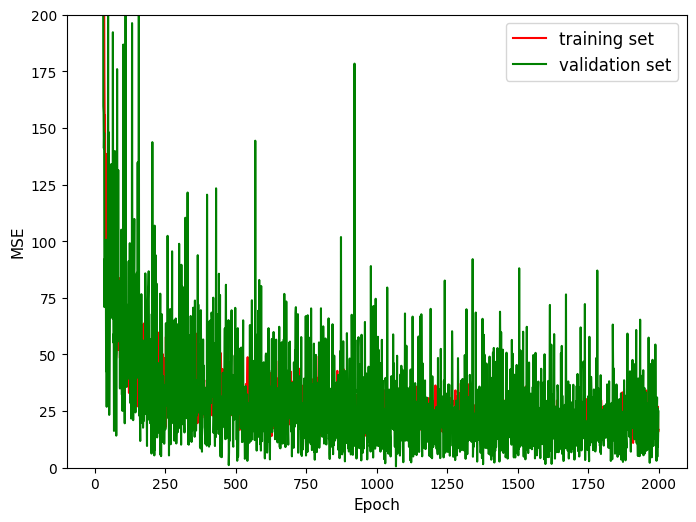

In [34]:
plt.figure(figsize=(8, 6), dpi=100)

plt.plot(model_train.history['loss'], color='r', )
plt.plot(model_train.history['val_loss'], color='g')

plt.ylabel('MSE', fontsize=11)
plt.xlabel('Epoch', fontsize=11)
plt.legend(['training set', 'validation set'], loc='upper right', fontsize=12)
plt.xticks(fontsize=10)
plt.ylim(0, 200)

In [31]:
# Generate test data
test_batch_size = 500
# x_test = np.random.uniform(0, 2., test_batch_size)
x_test = np.linspace(0, 1.3, test_batch_size)

mc_dropout_num = 200 # Run Dropout 100 times
predictions = np.zeros((mc_dropout_num, test_batch_size, 2))
uncertainty = np.zeros((mc_dropout_num, test_batch_size, 1))
for i in range(mc_dropout_num):
    predictions[i] = model.predict(scalerz.transform(x_test.reshape(-1,1)))
    
# get mean results and its varience
prediction_mc_dropout = np.mean(predictions, axis=0)
std_mc_dropout = np.std(predictions, axis=0)



16/16 [==============================] - 0s 1ms/step


16/16 [==============================] - 0s 1ms/step


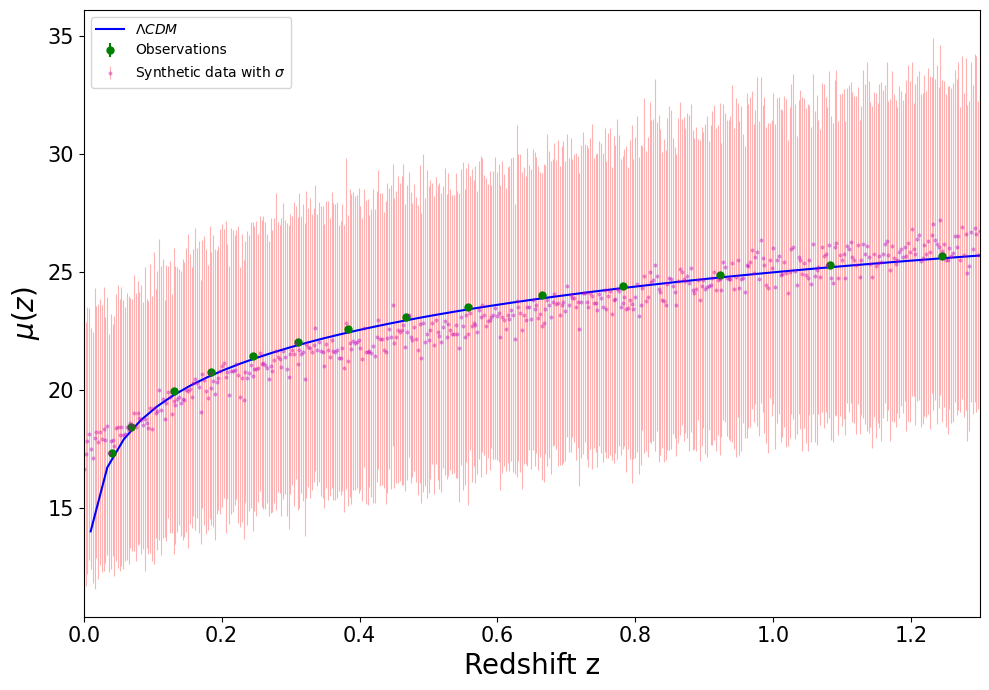

In [32]:
# Plotting
plt.figure(figsize=(10, 7), dpi=100)
# plt.figure(figsize=(5, 4), dpi=100)
sigma = np.sqrt(std_mc_dropout[:, 0]**2 + std_mc_dropout[:, 1]**2+ prediction_mc_dropout[:,1]**2)


# plt.scatter(scalerz.inverse_transform(zz), yy, color='k', label='Original cosmic chronometers')
plt.plot(zmodel, flcdm, label='$\Lambda CDM$', c='b')
plt.errorbar(dfp['zCMB'], dfp['MU']-19, dfp['errors'], fmt='g.', markersize=10, label='Observations')
plt.errorbar(x_test, prediction_mc_dropout[:,0]-19, yerr=sigma, markersize=2, fmt='o', 
             ecolor='r', capthick=2, elinewidth=0.8, alpha=0.3, c='m',
             label='Synthetic data with $\sigma$')

plt.xlim(0,1.3)

# plt.xlabel('Redshift')
# plt.ylabel('$H(z)$')
plt.ylabel("$\mu(z)$", fontsize=20)
plt.xlabel("Redshift z", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.legend(loc='best')
plt.legend(loc='upper left')
# plt.show()
plt.tight_layout()

# zCMB 	MU 	errors

(0.0, 200.0)

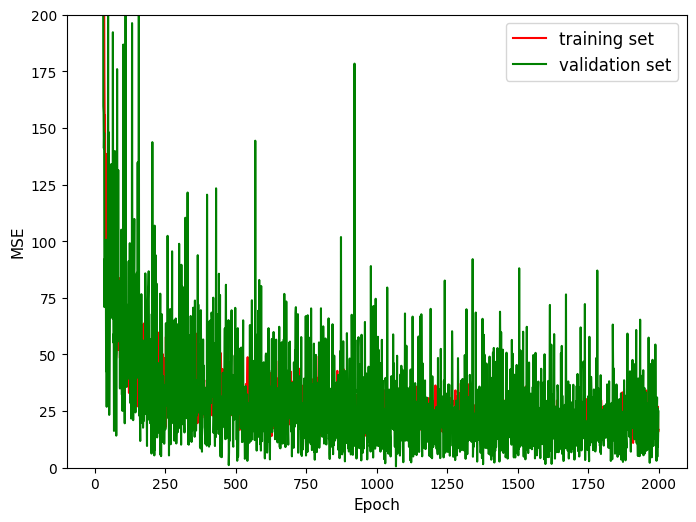